<a href="https://colab.research.google.com/github/PaulNjinu254/CNN1-Series/blob/main/CNN1_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1 - Loss: 0.1623
Epoch 2 - Loss: 0.1272
Epoch 3 - Loss: 0.1078
Epoch 4 - Loss: 0.0902
Epoch 5 - Loss: 0.0831
Accuracy: 0.9688


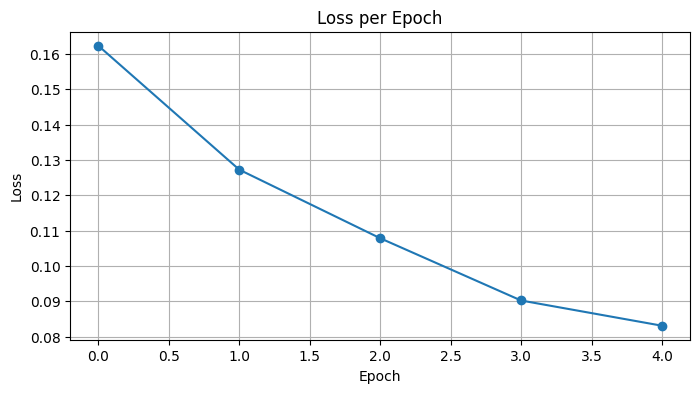

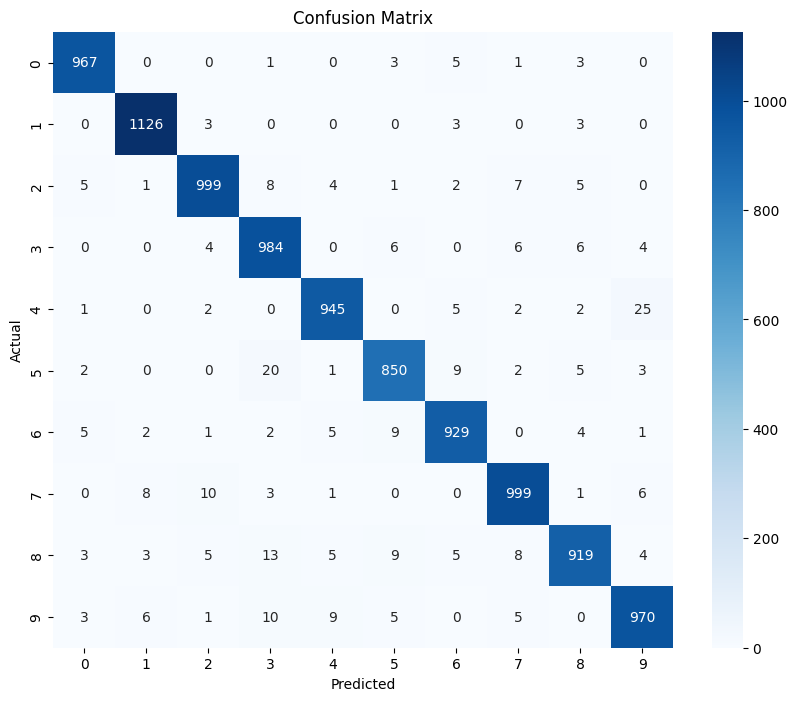

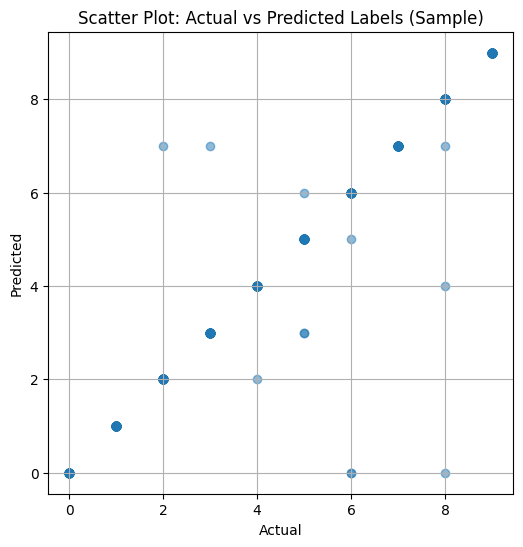

In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist

class Sigmoid:
    def forward(self, x):
        self.out = 1 / (1 + np.exp(-x))
        return self.out

    def backward(self, dout):
        return dout * self.out * (1 - self.out)

class Tanh:
    def forward(self, x):
        self.out = np.tanh(x)
        return self.out

    def backward(self, dout):
        return dout * (1 - self.out ** 2)

class ReLU:
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        return dout

class Softmax:
    def forward(self, x):
        x = x - np.max(x, axis=1, keepdims=True)
        self.out = np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)
        return self.out

    def backward(self, y):
        self.loss = self.loss_func(y, self.out)
        return (self.out - y) / y.shape[0]

    def loss_func(self, y, y_pred):
        return -np.sum(y * np.log(y_pred + 1e-7)) / y.shape[0]

class XavierInitializer:
    def __call__(self, shape):
        return np.random.randn(*shape) * np.sqrt(1.0 / shape[0])

class HeInitializer:
    def __call__(self, shape):
        return np.random.randn(*shape) * np.sqrt(2.0 / shape[0])

class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = {}

    def update(self, params, grads):
        for key in params.keys():
            if key not in self.h:
                self.h[key] = np.zeros_like(grads[key])
            self.h[key] += grads[key]**2
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

class FC:
    def __init__(self, input_dim, output_dim, initializer, optimizer):
        self.W = initializer((input_dim, output_dim))
        self.b = np.zeros(output_dim)
        self.optimizer = optimizer

    def forward(self, x):
        self.x = x
        return np.dot(x, self.W) + self.b

    def backward(self, dout):
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)
        dx = np.dot(dout, self.W.T)
        self.optimizer.update({'W': self.W, 'b': self.b}, {'W': dW, 'b': db})
        return dx

class Conv1d:
    def __init__(self, b_size, initializer, optimizer, n_in_channels, n_out_channels, pa, stride):
        self.b_size = b_size
        self.pa = pa
        self.stride = stride
        self.W = initializer((n_out_channels, n_in_channels, b_size))
        self.b = np.zeros(n_out_channels)
        self.optimizer = optimizer

    def forward(self, x):
        self.x = np.pad(x, ((0, 0), (0, 0), (self.pa, self.pa)), mode='constant')
        N, C, L = self.x.shape
        out_length = (L - self.b_size) // self.stride + 1
        col = np.zeros((N, self.W.shape[0], out_length))

        for i in range(out_length):
            col[:, :, i] = np.tensordot(self.x[:, :, i * self.stride:i * self.stride + self.b_size], self.W, axes=([1, 2], [1, 2])) + self.b
        self.col = col
        return col

    def backward(self, dout):
        # Simplified dummy backward pass (no gradient update for W and b)
        return dout

class GetMiniBatch:
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.batch_count = 0
        self.index = np.random.permutation(np.arange(X.shape[0]))

    def __iter__(self):
        return self

    def __next__(self):
        if self.batch_count * self.batch_size >= self.X.shape[0]:
            raise StopIteration
        i = self.batch_count * self.batch_size
        batch_X = self.X[self.index[i:i+self.batch_size]]
        batch_y = self.y[self.index[i:i+self.batch_size]]
        self.batch_count += 1
        return batch_X, batch_y

# Output size calculation for conv1d
def output_size_calculation(input_size, kernel_size, padding, stride):
    return (input_size + 2 * padding - kernel_size) // stride + 1


class Scratch1dCNNClassifier:
    def __init__(self, num_epoch=10, lr=0.01, batch_size=20, n_features=784, n_nodes2=100, n_output=10, verbose=True, Activater=ReLU, Optimizer=AdaGrad):
        self.num_epoch = num_epoch
        self.lr = lr
        self.batch_size = batch_size
        self.verbose = verbose
        self.n_features = n_features
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.Activater = Activater
        self.Optimizer = Optimizer

        if Activater == Sigmoid or Activater == Tanh:
            self.Initializer = XavierInitializer
        elif Activater == ReLU:
            self.Initializer = HeInitializer

    def fit(self, X, y, X_val=None, y_val=None):
        self.Conv1d = Conv1d(
            b_size=7,
            initializer=self.Initializer(),
            optimizer=self.Optimizer(self.lr),
            n_in_channels=1,
            n_out_channels=1,
            pa=1,
            stride=1
        )

        self.Conv1d.n_out = output_size_calculation(
            X.shape[-1],
            self.Conv1d.b_size,
            self.Conv1d.pa,
            self.Conv1d.stride
        )

        self.activation1 = self.Activater()
        self.FC2 = FC(1 * self.Conv1d.n_out, self.n_nodes2, self.Initializer(), self.Optimizer(self.lr))
        self.activation2 = self.Activater()
        self.FC3 = FC(self.n_nodes2, self.n_output, self.Initializer(), self.Optimizer(self.lr))
        self.activation3 = Softmax()
        self.loss = []
        self.loss_epoch = []

        for epoch in range(self.num_epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
            for mini_X, mini_y in get_mini_batch:
                self.forward_propagation(mini_X)
                self.back_propagation(mini_y)
                self.loss.append(self.activation3.loss)

            epoch_loss = self.activation3.loss_func(y, self.forward_propagation(X))
            self.loss_epoch.append(epoch_loss)

            if self.verbose:
                print(f"Epoch {epoch + 1} - Loss: {epoch_loss:.4f}")

    def forward_propagation(self, X):
        A1 = self.Conv1d.forward(X)
        A1 = A1.reshape(A1.shape[0], A1.shape[-1])  # Flatten conv output
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3

    def back_propagation(self, y_true):
        dA3 = self.activation3.backward(y_true)
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dA1 = dA1[:, np.newaxis]  # Add channel dimension
        _ = self.Conv1d.backward(dA1)

    def predict(self, X):
        return np.argmax(self.forward_propagation(X), axis=1)

# Load and prepare MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 1, 784) / 255
X_test = X_test.reshape(-1, 1, 784) / 255

encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

# Initialize and train the model
cnn = Scratch1dCNNClassifier(num_epoch=5, lr=0.01, batch_size=32, n_features=784, n_nodes2=100, n_output=10, verbose=True, Activater=ReLU, Optimizer=AdaGrad)
cnn.fit(X_train, y_train_onehot)

# Predict and evaluate
y_pred = cnn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Plot loss per epoch
plt.figure(figsize=(8, 4))
plt.plot(cnn.loss_epoch, marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Scatter plot (actual vs predicted)
plt.figure(figsize=(6, 6))
plt.scatter(y_test[:500], y_pred[:500], alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Scatter Plot: Actual vs Predicted Labels (Sample)")
plt.grid(True)
plt.show()
